In [1]:
# Import necessary libraries
import pandas as pd
# import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
import time

# Define functions for data preprocessing and model evaluation

In [26]:
# Function to preprocess categorical columns
def preprocess_categorical(data, cols):
    for col in cols:
        # Assuming '-' represents missing values, we replace them with 'None'
        data[col] = data[col].replace('-', 'None')
        # Convert all columns to string type and then encode
        data[col] = LabelEncoder().fit_transform(data[col].astype(str))
    return data

In [27]:
# Function to preprocess data and split into train-test sets with PCA
def preprocess_data_with_pca(df, n_components=10):
    # Remove 'id' and 'attack_cat' columns from the DataFrame
    df = df.drop(columns=['id', 'attack_cat'])

    # Identify columns with categorical data
    categorical_cols = df.select_dtypes(include=['object']).columns
    # Preprocess categorical columns using a helper function called preprocess_categorical
    df = preprocess_categorical(df, categorical_cols)

    # After encoding, check if there are any remaining non-numeric columns
    non_numeric_cols = df.select_dtypes(include=['object']).columns
    if len(non_numeric_cols) > 0:
        raise ValueError(f"Non-numeric columns remain: {non_numeric_cols}")

    # Get the list of columns in the DataFrame
    columns = df.columns.tolist()
    # Compute the correlation matrix of the DataFrame
    corr = df.corr()
    correlated_vars = []
    # Identify highly correlated variables (with correlation > 0.98) and store their names
    for i in range(len(columns) - 1):
        for j in range(i + 1, len(columns)):
            if corr[columns[i]][columns[j]] > 0.98:
                correlated_vars.append(columns[j])
    # Drop highly correlated variables from the DataFrame
    df = df.drop(columns=correlated_vars)

    # Separate features (X) and target variable (y) from the DataFrame
    x = df.drop(columns=['label'])
    y = df['label']

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x)

    # Apply PCA with the specified number of components
    pca = PCA(n_components=n_components)
    x_pca = pca.fit_transform(x_scaled)

    # Split the data into training and testing sets using train_test_split function
    x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size=0.3, random_state=42)

    # Return the original features, x_train, x_test, y_train, y_test
    return X, x_train, x_test, y_train, y_test

In [28]:
# Define models and hyperparameter grids
models = {
    'Random Forest Classifier': RandomForestClassifier(class_weight='balanced'),
    'Decision Tree Classifier': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=500),
    'kNN': KNeighborsClassifier(n_neighbors=5),
    'XGBoost': XGBClassifier(),
    'Extra Trees': ExtraTreesClassifier()
}

param_grid = {
    "Random Forest Classifier": {'n_estimators': [100, 200], 'max_depth': [10, 20]},
    "Decision Tree Classifier": {'max_depth': [10, 20]},
    "Logistic Regression": {'C': [0.01, 0.1, 1]},
    "kNN": {'n_neighbors': [5]},
    "XGBoost": {'n_estimators': [100, 200], 'max_depth': [10, 20], 'learning_rate': [0.1, 0.5]},
    "Extra Trees": {'n_estimators': [100, 200], 'max_depth': [10, 20]}
}

In [29]:
# DataFrame to store model performance metrics
model_performance = pd.DataFrame(columns=['Accuracy', 'Train Score', 'Precision', 'Recall', 'F1-Score', 'Time to Train', 'Time to Predict', 'Total Time'])

In [30]:
# Load and preprocess the dataset
# Load the training dataset into a DataFrame named df_train
df_train = pd.read_csv("/Users/ruimin1/Desktop/UNSW_NB15_training-set.csv")

# Load the testing dataset into another DataFrame named df_test
df_test = pd.read_csv("/Users/ruimin1/Desktop/UNSW_NB15_testing-set.csv")

# Concatenate (combine) the training and testing DataFrames along their rows, 
# effectively merging them into a single DataFrame named df
df = pd.concat([df_train, df_test])
# preprocess the dataset
print(df.columns)

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')


In [31]:
# Load and preprocess the dataset
# Load the training dataset into a DataFrame named df_train
df_train = pd.read_csv("/Users/ruimin1/Desktop/UNSW_NB15_training-set.csv")

# Load the testing dataset into another DataFrame named df_test
df_test = pd.read_csv("/Users/ruimin1/Desktop/UNSW_NB15_testing-set.csv")

# Concatenate (combine) the training and testing DataFrames along their rows, 
# effectively merging them into a single DataFrame named df
df = pd.concat([df_train, df_test])

In [32]:
# preprocess the dataset
X, x_train, x_test, y_train, y_test = preprocess_data_with_pca(df)

In [33]:
# Train, predict, evaluate models with hyperparameter tuning
for name, model in models.items():
    
    grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring='accuracy', n_jobs=-1) # Performs a grid search using cross-validation
    start_train_time = time.time()
    grid_search.fit(x_train, y_train) # Trains the model using the training data (x_train, y_train) 
    end_train_time = time.time()

    # Uses the best model identified from the grid search to predict the target values (y_pred) using the test data (x_test). 
    best_model = grid_search.best_estimator_
    start_predict_time = time.time()
    y_pred = best_model.predict(x_test)
    end_predict_time = time.time()

    # Performance Metrics Calculation
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Calculate total time (training + prediction)
    total_time = end_train_time - start_train_time + end_predict_time - start_predict_time
    # Compute training score
    train_score = best_model.score(x_train, y_train)
    
    # Model Performance Recording
    model_performance.loc[name] = [accuracy, train_score, precision, recall, f1, end_train_time - start_train_time, end_predict_time - start_predict_time, total_time]

In [34]:
# Find the best model based on a chosen metric
best_model_name = model_performance['Accuracy'].idxmax()
best_model = models[best_model_name]

In [35]:
# Train the best model
best_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

/Users/ruimin1/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ruimin1/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ruimin1/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


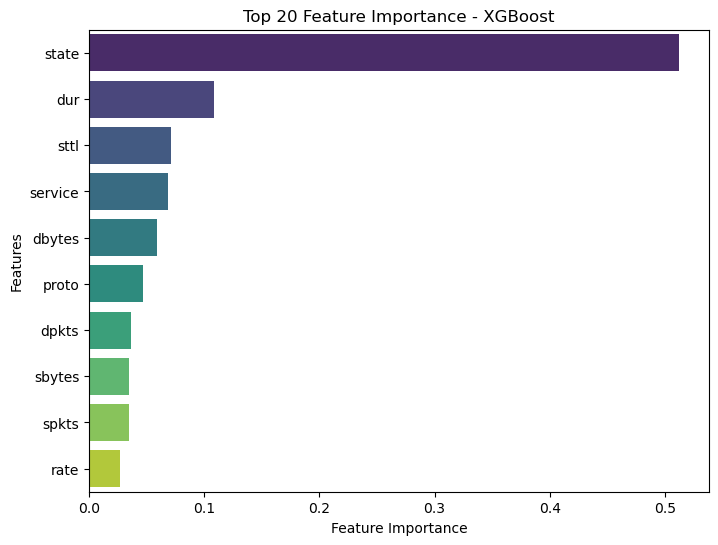

In [36]:
# Visualize feature importance (if applicable)
if hasattr(best_model, 'feature_importances_') and hasattr(best_model, 'n_features_in_'):
    feature_importances = pd.Series(best_model.feature_importances_, index=X.columns[:best_model.n_features_in_])
    sorted_features = feature_importances.sort_values(ascending=False).head(20)

    # Visualization for top10 features
    plt.figure(figsize=(8, 6))
    sns.barplot(x=sorted_features, y=sorted_features.index, palette='viridis', orient='h')
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title(f'Top 10 Feature Importance - {best_model_name}')
    plt.show()

<Figure size 1000x600 with 0 Axes>

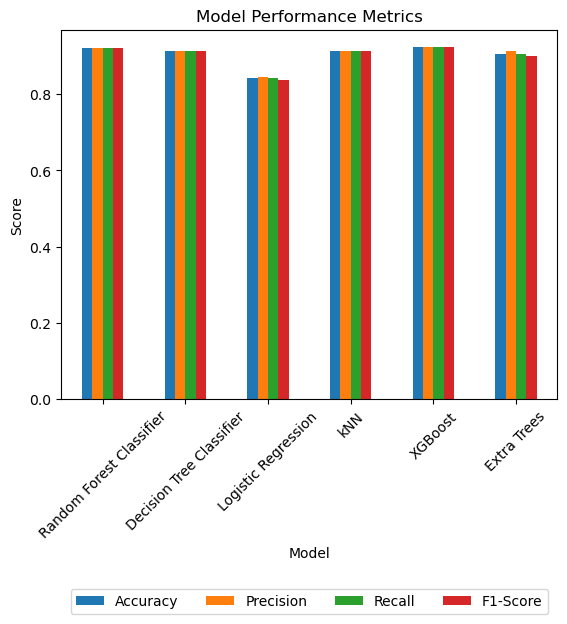

In [37]:
# Visualize performance comparison across models
plt.figure(figsize=(10, 6))
model_performance[['Accuracy', 'Precision', 'Recall', 'F1-Score']].plot(kind='bar')
plt.title('Model Performance Metrics')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=len(models))
plt.show()

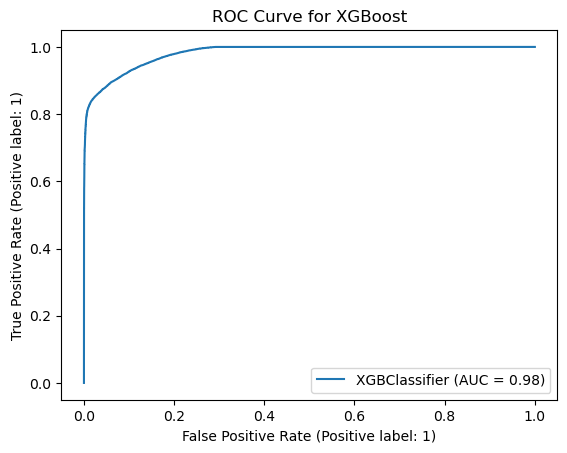

In [38]:
# Generate ROC Curve for the best model
roc_display = RocCurveDisplay.from_estimator(best_model, x_test, y_test)
plt.title(f'ROC Curve for {best_model_name}')
plt.show()

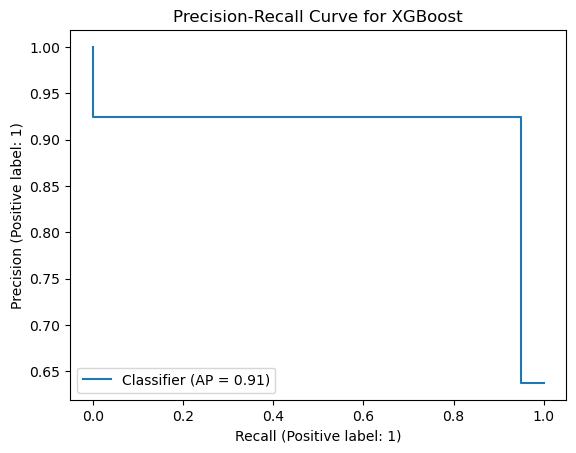

In [39]:
# Generate Precision-Recall Curve for the best model
y_pred_best = best_model.predict(x_test)
precision_recall_display = PrecisionRecallDisplay.from_predictions(y_test, y_pred_best)
plt.title(f'Precision-Recall Curve for {best_model_name}')
plt.show()

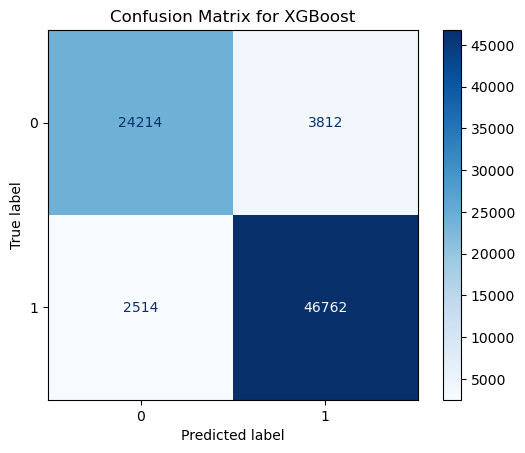

In [40]:
# Generate Confusion Matrix for the best model
cm_best = confusion_matrix(y_test, y_pred_best, labels=best_model.classes_)
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=best_model.classes_)
disp_best.plot(cmap='Blues')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()

In [41]:
# Style the DataFrame for better visualization
styled_performance = model_performance.style.background_gradient(cmap='coolwarm').format({
    'Accuracy': '{:.2%}',
    'Train Score': '{:.2%}',
    'Precision': '{:.2%}',
    'Recall': '{:.2%}',
    'F1-Score': '{:.2f}',
    'Time to Train': '{:.2f} s',
    'Time to Predict': '{:.2f} s',
    'Total Time': '{:.2f} s'
})
styled_performance

,Accuracy,Train Score,Precision,Recall,F1-Score,Time to Train,Time to Predict,Total Time
Random Forest Classifier,92.02%,97.48%,92.18%,92.02%,0.92,503.89 s,2.28 s,506.18 s
Decision Tree Classifier,91.21%,96.29%,91.22%,91.21%,0.91,10.53 s,0.02 s,10.55 s
Logistic Regression,84.23%,84.30%,84.49%,84.23%,0.84,2.32 s,0.00 s,2.32 s
kNN,91.30%,94.22%,91.30%,91.30%,0.91,4.53 s,5.91 s,10.44 s
XGBoost,92.27%,99.18%,92.24%,92.27%,0.92,88.17 s,0.11 s,88.28 s
Extra Trees,90.43%,91.23%,91.38%,90.43%,0.90,112.39 s,2.09 s,114.47 s
